In [165]:
import pandas as pd
import os
import pm4py
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
import re
import json

from functools import reduce
from itertools import groupby
from itertools import chain
from more_itertools import pairwise
from collections import Counter
import pygraphviz as pgv
from IPython.display import Image, display
from datetime import datetime


def draw_graph(log):

  log['trace'] = [trace.split(';') for trace in  log['Activity']]

  w_net = dict()
  ev_start_set = set()
  ev_end_set = set()
  for index, row in log[['trace','count']].iterrows():
    if row['trace'][0] not in ev_start_set:
      ev_start_set.add(row['trace'][0])
    if row['trace'][-1] not in ev_end_set:
      ev_end_set.add(row['trace'][-1])
    for ev_i, ev_j in pairwise(row['trace']):
      if ev_i not in w_net.keys():
        w_net[ev_i] = Counter()
      w_net[ev_i][ev_j] += row['count']

  G = pgv.AGraph(strict=False, directed=True)
  G.graph_attr['rankdir'] = 'LR'
  G.node_attr['shape'] = 'Mrecord'
  for event, succesors in w_net.items():
    G.add_node(event, style="rounded,filled", fillcolor="#ffffcc")
    G.add_edges_from([(event, sc) for sc in succesors])
  G.draw('simple_heuristic_net.png', prog='dot')
  display(Image('simple_heuristic_net.png'))

def draw_graph(dfs, case_id, timestamp, activity):
  ev_counter = dfs.Activity.value_counts()
  dfs = (dfs
      .sort_values(by=[case_id, timestamp])
      .groupby([case_id])
      .agg({activity: ';'.join})
  )
  dfs['count'] = 0
  dfs = (
      dfs.groupby(activity, as_index=False).count()
      .sort_values(['count'], ascending=False)
      .reset_index(drop=True)
  )
  dfs['trace'] = [trace.split(';') for trace in dfs[activity]]

  w_net = dict()
  ev_start_set = set()
  ev_end_set = set()
  for index, row in dfs[['trace','count']].iterrows():
      if row['trace'][0] not in ev_start_set:
          ev_start_set.add(row['trace'][0])
      if row['trace'][-1] not in ev_end_set:
          ev_end_set.add(row['trace'][-1])
      for ev_i, ev_j in pairwise(row['trace']):
          if ev_i not in w_net.keys():
              w_net[ev_i] = Counter()
          w_net[ev_i][ev_j] += row['count']

  trace_counts = sorted(chain(*[c.values() for c in w_net.values()]))
  trace_min = trace_counts[0]
  trace_max = trace_counts[-1]
  color_min = ev_counter.min()
  color_max = ev_counter.max()

  G = pgv.AGraph(strict= False, directed=True)
  G.graph_attr['rankdir'] = 'LR'
  G.node_attr['shape'] = 'Mrecord'

  G.add_node("start", shape="circle", label="")
  for ev_start in ev_start_set:
    G.add_edge("start", ev_start)

  for event, succesors in w_net.items():
    value = ev_counter[event]
    color = int(float(color_min-value)/float(color_min-color_max)*100.00)
    label = str(event) + ": " + str(ev_counter[event])
    my_color = "#ff9933"+str(hex(color))[2:]
    G.add_node(event, style="rounded,filled", fillcolor=my_color, label=label)
    for succesor, cnt in succesors.items():
      G.add_edge(event, succesor, penwidth=4*cnt/(trace_max-trace_min)+0.1, label=cnt)

  G.add_node("end", shape="circle", label="", penwidth='3')
  for ev_end in ev_end_set:
    G.add_edge(ev_end, "end")

  G.draw('simple_heuristic_net_with_events.png', prog='dot')
  display(Image('simple_heuristic_net_with_events.png'))

class ProcessTreeAdapter:

    @staticmethod
    def remove_brackets_between_single_quotes(expression):
        pattern = r"'(.*?)'"
        matches = re.findall(pattern, expression)

        for match in matches:
            replaced = match.replace('(', '').replace(')', '')
            expression = expression.replace(f"'{match}'", f"'{replaced}'")
        return expression

    @staticmethod
    def label_expressions(expression: str) -> str:
        labelled_expression = ""
        label_number = 0
        for c in expression:
            if c == '(':
                label_number += 1
                labelled_expression += f"({label_number}]"
            elif c == ')':
                labelled_expression += f"[{label_number})"
                label_number -= 1
            else:
                labelled_expression += c
        return labelled_expression

    @staticmethod
    def extract_arguments_from_labelled_expression(labelled_expression):
        #print(labelled_expression[labelled_expression.index("(")+1:labelled_expression.index("]")])
        #pattern_label_number = int(labelled_expression[-2])
        pattern_label_number = int(labelled_expression[labelled_expression.index("(")+1:labelled_expression.index("]")])
        trimmed_labelled_expression = labelled_expression[labelled_expression.index("]") + 1:-3]

        # print(labelled_expression)
        # print(trimmed_labelled_expression)
        # print(labelled_expression[-2])
        # print(labelled_expression[labelled_expression.index("(")+1:labelled_expression.index("]")])

        split = trimmed_labelled_expression.split(",")
        arguments = []
        brackets_counter = 0
        temp_arg = ""
        for s in split:
            brackets_counter += s.count('(')
            brackets_counter -= s.count(')')
            temp_arg += s + ","
            if brackets_counter == 0:
                temp_arg = temp_arg[:-1]
                arguments.append(temp_arg)
                temp_arg = ""
        return arguments, pattern_label_number

    @staticmethod
    def find_symbol(labelled_expression):
        pattern = r'^[^()]*'
        match = re.match(pattern, labelled_expression)
        if match:
            return re.sub(r'\s+', '', match.group())
        else:
            raise Exception("No match")

    @staticmethod
    def replace_spaces_with_underscore(tree):
        def replace_spaces(match):
            return re.sub(r'\s+', '_', match.group(0))

        text_with_underscore = re.sub(r"'(.*?)'", replace_spaces, tree)
        text_no_quotes = re.sub(r"'", '', text_with_underscore)

        return text_no_quotes

    @staticmethod
    def replace_symbol_with_name(labelled_pattern_expression, pattern_label_number, old_symbol, new_name):
        pattern = rf"{re.escape(old_symbol)}\(({pattern_label_number}\])"
        new_name = new_name + "(" + str(pattern_label_number) + "]"
        replaced_string = re.sub(pattern, new_name, labelled_pattern_expression)

        return replaced_string

    @staticmethod
    def get_highest_label(labelledExpression: str) -> int:
        maxLabel = -1
        active = False
        sb = ""
        for c in labelledExpression:
            if c == '(':
                active = True
            elif c == ']':
                if int(sb) > maxLabel:
                    maxLabel = int(sb)
                sb = ""
                active = False
            elif active:
                sb += c
        return maxLabel

class Sequence:
    @staticmethod
    def change_symbol_into_name(labelled_expression):
        pattern_symbol = '>'
        pattern_name = 'Seq'
        if len(labelled_expression) == 2:
            pattern_name = 'Seq2'
        elif len(labelled_expression) == 3:
            pattern_name = 'Seq3'
        elif len(labelled_expression) == 4:
            pattern_name = 'Seq4'
        elif len(labelled_expression) == 5:
            pattern_name = 'Seq5'
        else:
            raise Exception("pattern does not exist")
        return pattern_name

class Loop:
    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        pattern_symbol = '*'
        pattern_name = 'Loop'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        if len(labelled_expression) == 2:
            labelled_expression = ['l_s'] + labelled_expression
        else:
            raise Exception("pattern does not exist")
        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression

class ExclusiveChoice:
    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        pattern_symbol = 'X'
        pattern_name = 'Xor'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        if len(labelled_expression) == 2:
            pattern_name = 'Xor2'
            labelled_expression = ['x2_s'] + labelled_expression + ['x2_e']
        elif len(labelled_expression) == 3:
            pattern_name = 'Xor3'
            labelled_expression = ['x3_s'] + labelled_expression + ['x3_e']
        else:
            raise Exception("pattern does not exist")
        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression

class Parallelism:
    @staticmethod
    def change_symbol_into_name(labelled_expression, pattern_label_number):
        pattern_symbol = '+'
        pattern_name = 'And'
        labelled_expression_to_replace = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        if len(labelled_expression) == 2:
            pattern_name = 'And2'
            labelled_expression = ['a2_s'] + labelled_expression + ['a2_e']
        elif len(labelled_expression) == 3:
            pattern_name = 'And3'
            labelled_expression = ['a3_s'] + labelled_expression + ['a3_e']
        else:
            raise Exception("pattern does not exist")
        new_labelled_expression = "(" + str(pattern_label_number) + "]" + ",".join(labelled_expression) + "[" + str(pattern_label_number) + ")"
        return pattern_name, labelled_expression_to_replace, new_labelled_expression

class PatternExpressionGenerator:
    def __init__(self, converted_expression):
        self.converted_expression = converted_expression

    def add_approved_workflow_patterns(self, expression):
          if expression == None or isinstance(expression , list):
            return

          symbol = ProcessTreeAdapter.find_symbol(expression)
          pattern = r'>|X|\+|\*'
          matches = re.findall(pattern, expression)

          if (len(matches) != 0):
            arguments = ProcessTreeAdapter.extract_arguments_from_labelled_expression(expression)
            expression = arguments[0]
            pattern_label_number = arguments[1]
            if symbol == '>':
                new_name = Sequence.change_symbol_into_name(expression)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name)
            elif symbol == '*':
                new_name = Loop.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name[0])
                expression_to_replace = self.converted_expression
                self.converted_expression = expression_to_replace.replace(new_name[1], new_name[2])
            elif symbol == '+':
                new_name = Parallelism.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name[0])

                expression_to_replace = self.converted_expression
                self.converted_expression = expression_to_replace.replace(new_name[1], new_name[2])
            elif symbol == 'X':
                new_name = ExclusiveChoice.change_symbol_into_name(expression, pattern_label_number)
                self.converted_expression = ProcessTreeAdapter.replace_symbol_with_name(self.converted_expression, pattern_label_number, symbol, new_name[0])
                expression_to_replace = self.converted_expression
                self.converted_expression = expression_to_replace.replace(new_name[1], new_name[2])
            else:
                raise Exception("pattern does not exist")
          return expression

    def get_converted_expression(self):
        return self.converted_expression

def process_patterns(pattern_list, instance):
    new_pattern_list = []
    for pattern in pattern_list:
        new_pattern = instance.add_approved_workflow_patterns(pattern)
        if isinstance(new_pattern, list):
            new_pattern = process_patterns(new_pattern, instance)
        new_pattern_list.append(new_pattern)
    return new_pattern_list

def recursive_process(pattern_list, instance, depth):
    if depth <= 0:
        return pattern_list
    else:
        pattern_list = process_patterns(pattern_list, instance)
        return recursive_process(pattern_list, instance, depth - 1)

def get_pattern_expression(labelled_pattern_expression):
    pattern_list = []
    pattern_list.append(labelled_pattern_expression)
    pattern_expression_generator = PatternExpressionGenerator(labelled_pattern_expression)
    recursive_process(pattern_list, pattern_expression_generator, ProcessTreeAdapter.get_highest_label(labelled_pattern_expression))

    return pattern_expression_generator.get_converted_expression()

class WorkflowPatternTemplate:
    def __init__(self, name, number_of_arguments, rules):
        self.name = name
        self.number_of_arguments = number_of_arguments
        self.rules = rules

    @staticmethod
    def load_pattern_property_set(path_to_pattern_rules_file):
        with open(path_to_pattern_rules_file, 'r') as file:
            data = json.load(file)
            pattern_property_set = []
            for workflow_pattern_template_name, pattern_descr_json_object in data.items():
                number_of_arguments = pattern_descr_json_object["number of args"]
                rules = pattern_descr_json_object["rules"]
                workflow_pattern_template = WorkflowPatternTemplate(workflow_pattern_template_name, number_of_arguments, rules)
                pattern_property_set.append(workflow_pattern_template)
            return pattern_property_set

    def get_name(self):
        return self.name

    def set_name(self, name):
        self.name = name

    def get_number_of_arguments(self):
        return self.number_of_arguments

    def set_number_of_arguments(self, number_of_arguments):
        self.number_of_arguments = number_of_arguments

    def get_rules(self):
        return self.rules

    def set_rules(self, rules):
        self.rules = rules

class WorkflowPattern:
    def __init__(self, workflow_pattern_template, pattern_arguments):
        self.workflow_pattern_template = workflow_pattern_template
        self.pattern_arguments = pattern_arguments

    @staticmethod
    def get_workflow_pattern_from_expression(pattern_expression, pattern_property_set):
        workflow_name = pattern_expression[:pattern_expression.index("(")]
        workflow_pattern_template = next((template for template in pattern_property_set if template.get_name() == workflow_name), None)

        if workflow_pattern_template is None:
            raise Exception("Workflow pattern template not found!")
        pattern_arguments = WorkflowPattern.extract_arguments_from_labelled_expression(pattern_expression, pattern_property_set)
        return WorkflowPattern(workflow_pattern_template, pattern_arguments)

    @staticmethod
    def extract_arguments_from_labelled_expression(labelled_expression, pattern_property_set):
        workflow_name = labelled_expression[:labelled_expression.index("(")]
        workflow_pattern_template = next((template for template in pattern_property_set if template.get_name() == workflow_name), None)
        if workflow_pattern_template is None:
            raise Exception("Workflow pattern template not found!")

        number_of_arguments = workflow_pattern_template.get_number_of_arguments()
        #pattern_label_number = int(labelled_expression[-2])
        pattern_label_number = int(labelled_expression[labelled_expression.index("(") + 1:labelled_expression.index("]")])
        # print(pattern_label_number)
        # print(labelled_expression[-2])
        # print(labelled_expression[labelled_expression.index("(") + 1:labelled_expression.index("]")])
        trimmed_labelled_expression = labelled_expression[labelled_expression.index("]") + 1:-3]

        split = trimmed_labelled_expression.split(",")
        arguments = []
        brackets_counter = 0
        temp_arg = ""
        for s in split:
            brackets_counter += s.count('(')
            brackets_counter -= s.count(')')
            temp_arg += s + ","
            if brackets_counter == 0:
                temp_arg = temp_arg[:-1]
                arguments.append(temp_arg)
                temp_arg = ""

        if len(arguments) != number_of_arguments:
            print(labelled_expression)
            print(pattern_label_number)
            raise Exception(f"Found arguments ({arguments}) different from the required number ({number_of_arguments})")
        return arguments

    @staticmethod
    def count_occurrence_of_char(string, char):
        return string.count(char)

    @staticmethod
    def is_not_atomic(argument):
        return "=>" in argument or "|" in argument or "^" in argument or "]" in argument

    def get_workflow_pattern_template(self):
        return self.workflow_pattern_template

    def set_workflow_pattern_template(self, workflow_pattern_template):
        self.workflow_pattern_template = workflow_pattern_template

    def get_workflow_pattern_filled_rules(self):
        if len(self.pattern_arguments) > 0:
            outcomes = []
            for outcome in self.workflow_pattern_template.get_rules():
                outcome_with_params = outcome
                for i, arg in enumerate(self.pattern_arguments):
                    outcome_with_params = outcome_with_params.replace("arg" + str(i), arg)
                outcomes.append(outcome_with_params)
            return outcomes
        else:
            raise Exception("No arguments for the given pattern in the expression")

    def get_pattern_arguments(self):
        return self.pattern_arguments

    def set_pattern_arguments(self, pattern_arguments):
        self.pattern_arguments = pattern_arguments

from typing import List

class CalculatingConsolidatedExpression:

    @staticmethod
    def generate_consolidated_expression(pattern_expression: str, expression_type: str, pattern_property_set: List[WorkflowPatternTemplate]) -> str:

        if expression_type not in ("ini", "fin"):
            raise Exception("type must equal 'ini' or 'fin'!")

        ex = ""
        workflow_pattern = WorkflowPattern.get_workflow_pattern_from_expression(pattern_expression, pattern_property_set)
        rules_with_atomic_activities = workflow_pattern.get_workflow_pattern_filled_rules()
        ini = rules_with_atomic_activities[0]
        fin = rules_with_atomic_activities[1]
        rules_with_atomic_activities = rules_with_atomic_activities[2:]

        if expression_type == "ini":
            ex = ini
        else:
            ex = fin

        expression_arguments = WorkflowPattern.extract_arguments_from_labelled_expression(pattern_expression, pattern_property_set)
        for argument in expression_arguments:
            if WorkflowPattern.is_not_atomic(argument):
                inner_consolidated_expression = CalculatingConsolidatedExpression.generate_consolidated_expression(argument, expression_type, pattern_property_set)

                ex = ex.replace(argument, inner_consolidated_expression)
        return ex

from typing import List
import re
from collections import Counter

class GeneratingLogicalSpecifications:

    @staticmethod
    def generate_logical_specifications(pattern_expression: str, pattern_property_set: List[WorkflowPatternTemplate]) -> str:
        logical_specification = []
        labelled_expression = pattern_expression
        highest_label_number = ProcessTreeAdapter.get_highest_label(labelled_expression)
        for l in range(highest_label_number, 0, -1):
            c = 1
            pat = GeneratingLogicalSpecifications.get_pat(labelled_expression, l, c, pattern_property_set)
            while pat is not None:
                L2 = pat.get_workflow_pattern_filled_rules()
                L2 = L2[2:]
                for arg in pat.get_pattern_arguments():
                    if WorkflowPattern.is_not_atomic(arg):
                        cons = CalculatingConsolidatedExpression.generate_consolidated_expression(arg, "ini", pattern_property_set) + " | " + CalculatingConsolidatedExpression.generate_consolidated_expression(arg, "fin", pattern_property_set)
                        L2_cons = [outcome.replace(arg, cons) for outcome in L2]
                        L2 = L2_cons
                c += 1
                logical_specification.extend(L2)
                pat = GeneratingLogicalSpecifications.get_pat(labelled_expression, l, c, pattern_property_set)

        logical_specification = list(set(logical_specification))
        connected_string = ""
        print("\nWynik: ")
        for l_value in logical_specification:
            connected_string += l_value + ", "
            print(l_value)
        return connected_string

    @staticmethod
    def get_pat(labelled_expression: str, l: int, c: int, pattern_property_set: List[WorkflowPatternTemplate]) -> WorkflowPattern:
        entry_occurrences = labelled_expression.count("(" + str(l) + "]")
        end_occurrences = labelled_expression.count("[" + str(l) + ")")
        if entry_occurrences != end_occurrences:
            raise Exception("(" + str(l) + "] nie równa się [" + str(l) + ")")

        if entry_occurrences < c:
            return None

        expression_split_by_entry = re.split(rf"\({l}\]", labelled_expression)
        pattern_content = re.split(rf"\[{l}\)", expression_split_by_entry[c])[0]
        split_by_bracket = re.split(r"\]", expression_split_by_entry[c - 1])
        workflow_name = re.split(r",", split_by_bracket[-1])[-1]
        workflow_exp = workflow_name + f"({l}]" + pattern_content + f"[{l})"
        return WorkflowPattern.get_workflow_pattern_from_expression(workflow_exp, pattern_property_set)

pattern_rules= "approved_patterns.json"
ltl_pattern_property_set = WorkflowPatternTemplate.load_pattern_property_set(pattern_rules)

def get_results(pattern_expression):
    print(pattern_expression)

    ini = CalculatingConsolidatedExpression.generate_consolidated_expression(pattern_expression.replace(" ", ""), "ini", ltl_pattern_property_set)
    print("ini: " + ini)
    fin = CalculatingConsolidatedExpression.generate_consolidated_expression(pattern_expression.replace(" ", ""), "fin", ltl_pattern_property_set)
    print("fin: " + fin)

    GeneratingLogicalSpecifications.generate_logical_specifications(pattern_expression.replace(" ", ""), ltl_pattern_property_set)


In [166]:
def import_xes(file_path):
    data = pm4py.read_xes(file_path)
    print(data.head())
    # with open(file_path, 'r') as f:
    #     data = f.read()
    #     data = BeautifulSoup(data, "xml")
    return data

log_1 = pm4py.read_xes("running-example.xes")
log_2 = pm4py.read_xes("Hospital Billing - Event Log.xes")
log_3 = pm4py.read_xes("Sepsis Cases - Event Log.xes")

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\conversion\log\variants\to_data_frame.py:73: UserWarning: no explicit representation of timezones available for np.datetime64
  ev[attr] = np.datetime64(ev[attr])
D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\log\util\datafr

parsing log, completed traces ::   0%|          | 0/100000 [00:00<?, ?it/s]

D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\conversion\log\variants\to_data_frame.py:73: UserWarning: no explicit representation of timezones available for np.datetime64
  ev[attr] = np.datetime64(ev[attr])
D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\log\util\datafr

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\conversion\log\variants\to_data_frame.py:73: UserWarning: no explicit representation of timezones available for np.datetime64
  ev[attr] = np.datetime64(ev[attr])
D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\log\util\dataframe_utils.py:176: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
D:\JetBrains\Projects\StudioProject\.venv\lib\site-packages\pm4py\objects\log\util\datafr

In [180]:
log_3

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,True,A,True,True,True,True,True,True,True,ER Registration,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15209,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,66.0,NaN
15210,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Release A,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,NaN,NaN
15211,False,L,False,False,False,False,False,False,False,ER Registration,...,False,complete,NaN,False,False,False,LNA,NaN,NaN,NaN
15212,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,LNA,NaN,NaN,NaN


In [167]:
process_tree_1 = pm4py.discover_process_tree_inductive(
    log_1,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)

In [168]:
process_tree_2 = pm4py.discover_process_tree_inductive(
    log_2,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)

In [169]:
process_tree_3 = pm4py.discover_process_tree_inductive(
    log_3,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
)

In [170]:
pm4py.save_vis_process_tree(process_tree_1, 'process_tree.png')

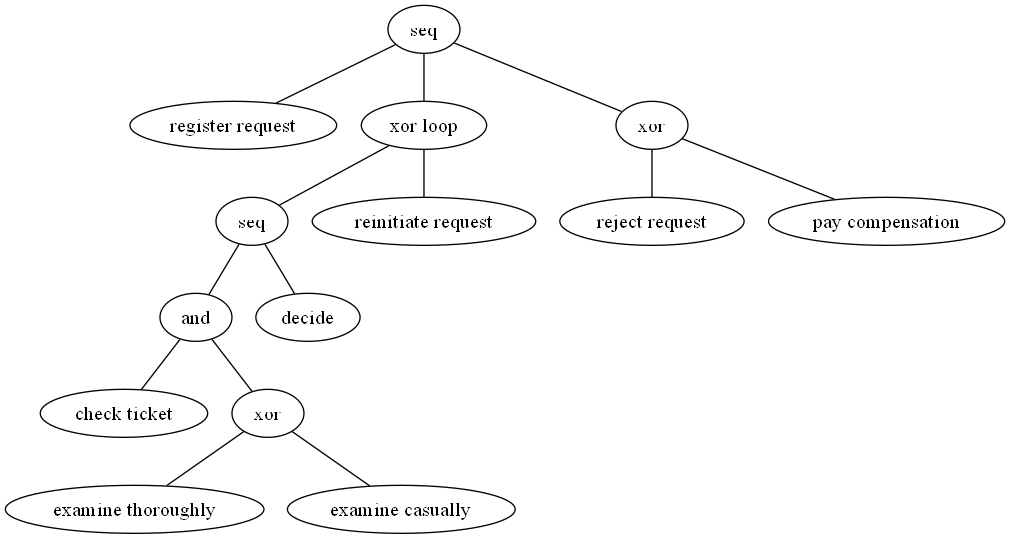

In [171]:
pm4py.view_process_tree(process_tree_1)

In [172]:
W1 = str(process_tree_1)
W1 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W1)
W1 = ProcessTreeAdapter.replace_spaces_with_underscore(W1)
W1 = W1.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")
labelled_pattern_expression1 = ProcessTreeAdapter.label_expressions(W1)
pattern_expression1 = get_pattern_expression(labelled_pattern_expression1)

In [173]:
W2 = str(process_tree_2)
W2 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W2)
W2 = ProcessTreeAdapter.replace_spaces_with_underscore(W2)
W2 = W2.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")
labelled_pattern_expression2 = ProcessTreeAdapter.label_expressions(W2)
pattern_expression2 = get_pattern_expression(labelled_pattern_expression2)

In [174]:
W3 = str(process_tree_3)
W3 = ProcessTreeAdapter.remove_brackets_between_single_quotes(W3)
W3 = ProcessTreeAdapter.replace_spaces_with_underscore(W3)
W3 = W3.replace("( ", "(").replace(") ", ")").replace(" )", ")").replace("->", ">")
labelled_pattern_expression3 = ProcessTreeAdapter.label_expressions(W3)
pattern_expression3 = get_pattern_expression(labelled_pattern_expression3)

In [175]:
get_results(pattern_expression1)

Seq3(1]register_request, Loop(2]l_s,Seq2(3]And2(4]a2_s,check_ticket, Xor2(5]x2_s,examine_thoroughly, examine_casually,x2_e[5),a2_e[4), decide[3), reinitiate_request[2), Xor2(2]x2_s,pay_compensation, reject_request,x2_e[2)[1)
ini: register_request
fin: x2_e

Wynik: 
ForAll(~((examine_thoroughly) ^ (examine_casually)))
ForAll(~((l_s) ^ (reinitiate_request)))
ForAll(~((register_request) ^ (x2_s | x2_e)))
ForAll(((examine_thoroughly) | (examine_casually)) => Exist(x2_e))
ForAll(~((l_s | decide) ^ (x2_s | x2_e)))
ForAll(~((pay_compensation) ^ (x2_e)))
ForAll(~((reject_request) ^ (x2_e)))
ForAll((x2_s) => ((Exist(examine_thoroughly) ^ ~(Exist(examine_casually))) | (~(Exist(examine_thoroughly)) ^ Exist(examine_casually))))
ForAll(~((l_s) ^ (a2_s | decide)))
ForAll((l_s) => Exist(a2_s | decide))
ForAll(~((pay_compensation) ^ (reject_request)))
Exist(x2_s)
Exist(l_s)
ForAll((check_ticket) => Exist(a2_e))
ForAll((reinitiate_request) => Exist(a2_s | decide))
ForAll(~((a2_s | a2_e) ^ (decide)))
Fo

In [176]:
get_results(pattern_expression2)

Seq2(1]Loop(2]l_s,NEW, tau[2), Xor2(2]x2_s,tau, And2(3]a2_s,Xor2(4]x2_s,tau, Loop(5]l_s,JOIN-PAT, tau[5),x2_e[4), Xor2(4]x2_s,tau, Seq2(5]Xor2(6]x2_s,tau, Seq2(7]And2(8]a2_s,Xor2(9]x2_s,tau, Loop(10]BILLED, tau[10),x2_e[9), Xor2(9]x2_s,tau, Seq2(10]Loop(11]Xor3(12]Seq2(13]Xor2(14]tau, SET_STATUS[14), Xor2(14]tau, And2(15]Xor2(16]tau, Loop(17]CODE_ERROR, tau[17)[16), Seq2(16]Xor2(17]tau, Loop(18]RELEASE, tau[18)[17), Xor2(17]tau, Xor2(18]CODE_OK, MANUAL[18)[17), Xor2(17]tau, +(18]X(19]tau, *(20]CODE_NOK, tau[20)[19), X(19]tau, >(20]X(21]tau, *(22]>(23]STORNO, X(24]tau, *(25]REJECT, tau[25)[24)[23), tau[22)[21), X(21]tau, +(22]X(23]tau, *(24]REOPEN, tau[24)[23), X(23]tau, FIN[23)[22)[21)[20)[19)[18)[17)[16)[15)[14)[13), CHANGE_DIAGN, CHANGE_END[12), tau[11), Xor2(11]tau, ZDBC_BEHAN[11)[10),x2_e[9),a2_e[8), Xor2(8]x2_s,tau, EMPTY,x2_e[8)[7),x2_e[6), Xor2(6]x2_s,tau, Loop(7]l_s,DELETE, tau[7),x2_e[6)[5),x2_e[4),a2_e[3),x2_e[2)[1)
Loop(10]BILLED,tau[10)
10


Exception: Found arguments (['BILLED', 'tau[']) different from the required number (3)

In [177]:
get_results(pattern_expression3)

And2(1]a2_s,ER_Registration, And2(2]a2_s,Xor2(3]x2_s,tau, Return_ER,x2_e[3), Seq2(3]And2(4]a2_s,Xor2(5]x2_s,tau, Release_B,x2_e[5), And3(5]a3_s,Xor2(6]x2_s,tau, Loop(7]l_s,Leucocytes, tau[7),x2_e[6), Xor2(6]tau, Loop(7]l_s,CRP, tau[7)[6), And2(6]a2_s,Xor2(7]x2_s,tau, Loop(8]l_s,LacticAcid, tau[8),x2_e[7), Seq2(7]And2(8]a2_s,Xor2(9]x2_s,tau, And2(10]Xor2(11]tau, Loop(12]Admission_NC, tau[12)[11), Xor2(11]tau, IV_Liquid[11)[10),x2_e[9), And2(9]Seq2(10]Loop(11]ER_Triage, tau[11), Xor2(11]tau, Loop(12]Admission_IC, tau[12)[11)[10), Xor2(10]tau, Seq2(11]ER_Sepsis_Triage, Xor2(12]tau, IV_Antibiotics[12)[11)[10)[9),a2_e[8), Xor2(8]x2_s,tau, Release_A,x2_e[8)[7),a2_e[6),a3_e[5),a2_e[4), Xor2(4]tau, Xor2(5]x3_s,Release_E, Release_C, Release_D,x3_e[5)[4)[3),a2_e[2),a2_e[1)
Xor2(6]tau,Loop(7]l_s,CRP,tau[7)[6)
6


Exception: Found arguments (['tau', 'Loop(7]l_s,CRP,tau[7)']) different from the required number (4)